In [90]:
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import misc
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from matplotlib.pyplot import figure
import matplotlib.patches as patches
import matplotlib as mpl
import os
import scipy.stats as scpstats
from PIL import Image
mpl.rcParams['figure.dpi'] = 100

def block_route(iref, ipred, bs ): # J'ai une variante parallelisable en réserve mais ma librairie fonctionne pas sur colab
    """
    Application d'une fonction func pour chaque blocs de l'image.
    """
    n, m = np.shape(iref)[:2]
    ncol = int(m // bs)
    nrow = int(n // bs)
    padding = 10 # à voir plus tard
    tabx = [] # stockage décalage x
    taby = [] # stockage décalage y
    for i in range(nrow):
        for j in range(ncol):
        # if i * ncol + j  >= start and i * ncol + j < end: # Vérification que le processus doit bien traiter ce bloc
            block_ref = np.copy(iref[i * bs : i * bs + bs , j * bs : j * bs + bs])  # Selection des blocs sur band 1 et 2
            block_pred = np.copy(ipred[i * bs : i * bs + bs , j * bs : j * bs + bs])  # Selection des blocs sur band 1 et 2
            template = np.copy(block_ref[padding:bs - padding, padding:bs - padding])  # Selection du sous bloc
            orig, temp, corr, x, y = decalageBloc(block_pred, template, padding) # Calcul du déplacement
            xm = x - bs / 2
            ym = y - bs / 2
            tabx.append(xm)
            taby.append(ym)
    return tabx, taby


def decalageBloc(original, template, padding):
    p = padding
    orig = np.copy(original)  #prévenir pbs de pointeurs python
    temp = np.copy(template)

    # Normalisation des données
    orig -= original.mean(dtype="uint8")
    orig = orig/np.std(orig)
    temp -= template.mean(dtype="uint8")
    temp = temp/np.std(temp)

    corr = signal.correlate2d(orig, temp, boundary='symm', mode='same')
    n,m = np.shape(corr)
    n_middle = n // 2
    m_middle = m // 2

    # Selection du domaine admissible pour la recherche du déplacement, correpondant au carré de coté 2 x padding
#     corr_admissible = corr[n_middle - p:n_middle + p, m_middle - p:m_middle + p]
    corr_admissible = corr
    
    plt.pcolormesh(corr)
    plt.show()
    input()
    y, x = np.unravel_index(np.argmax(corr_admissible), corr_admissible.shape)  # find the match (max of correlation)
    y = y + m_middle - p
    x = x + n_middle - p

    return orig, temp, corr, x, y

def visualize_block(img, block_size):

    f = 1 # facteur de recouvrement
    bs = block_size #plus court pour le code
    n,m = np.shape(img)
    fig,ax = plt.subplots(1,1,figsize=(15,20))
    ax.imshow(img)
    ncol = int(m // bs )
    to_crop_horizontal = m % bs
    nrow = int(n // bs )
    to_crop_vertical = n % bs

    nb_block = nrow * ncol      # Nombre de blocs dans l'image
    print(f"Info:\n\
    -> Shape de l'image : {n}x{m}px\n\
    -> Block size : {block_size}px\n\
    -> Nombre de blocs : {nb_block} pbs d'optim à résoudre\n\
    -> A crop horizontalement pour tomber pile : {to_crop_horizontal}px\n\
    -> A crop verticalement pour tomber pile : {to_crop_vertical}px\n")
    for i in range(nrow) :
        for j in range(ncol) :
            rect = patches.Rectangle( (j * bs, i * bs), bs, bs,linewidth=1,edgecolor='k',facecolor='none')
            ax.add_patch(rect)
    plt.show()

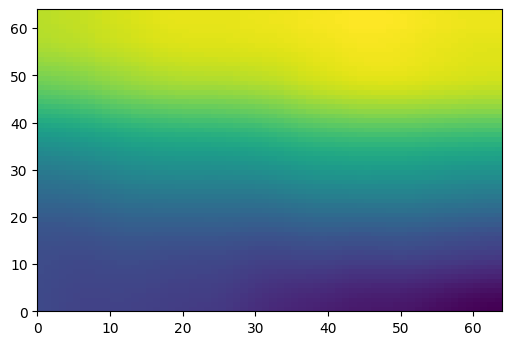

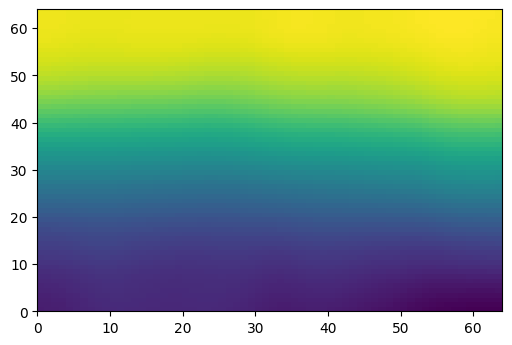

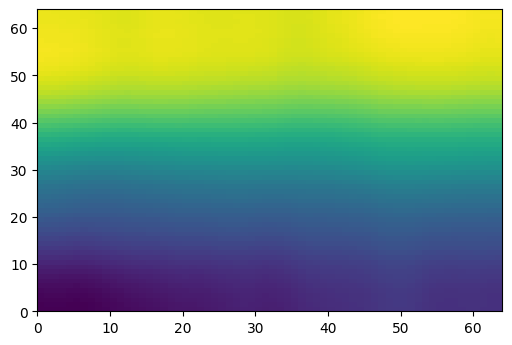

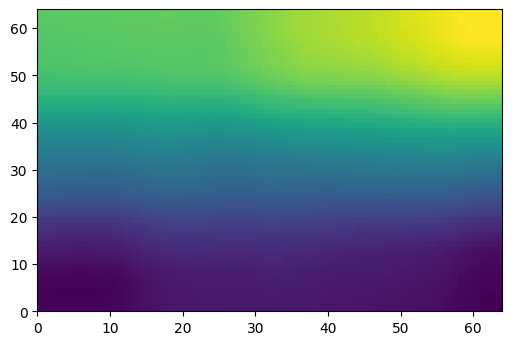

In [ ]:
bs = 64
iref = np.array(Image.open("img/1.jpg"))[:,:,0]
ipred = np.array(Image.open("img/2.jpg"))[:,:,0]
tabx,taby = block_route(iref,ipred,bs)
print(list(tabx))
print(list(taby))

Info:
    -> Shape de l'image : 1080x1920px
    -> Block size : 64px
    -> Nombre de blocs : 480 pbs d'optim à résoudre
    -> A crop horizontalement pour tomber pile : 0px
    -> A crop verticalement pour tomber pile : 56px



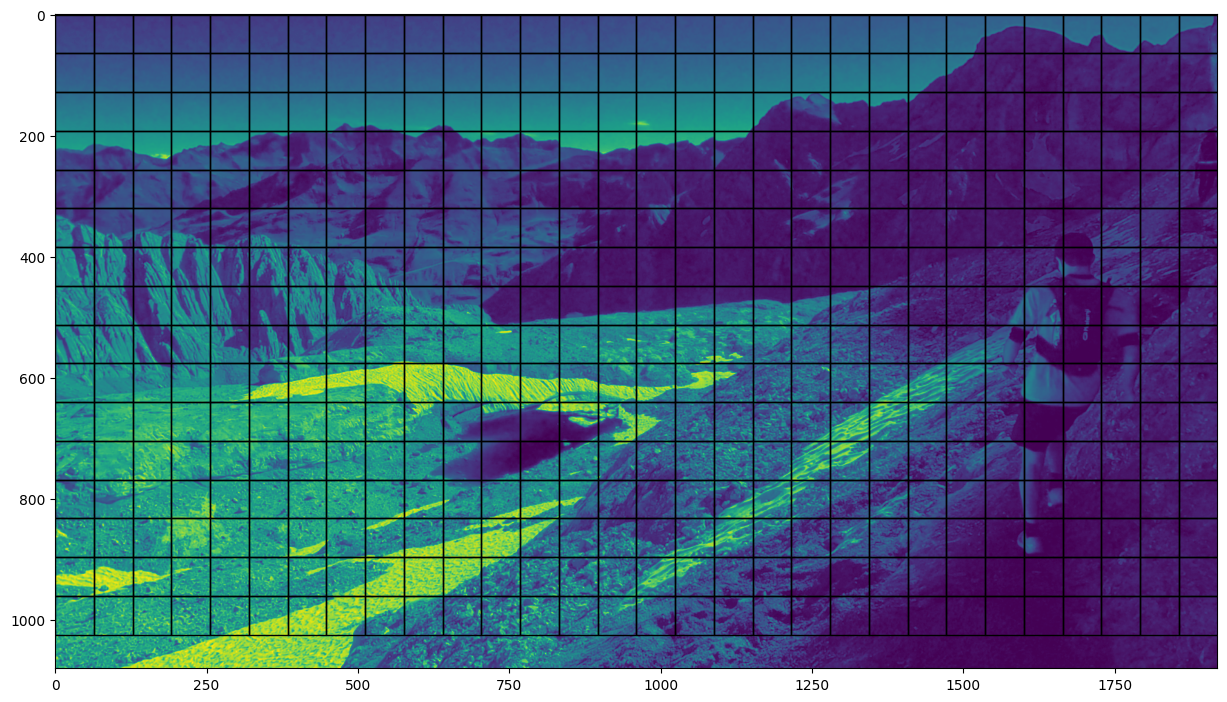

In [84]:
visualize_block(iref, 64)

Info:
    -> Shape de l'image : 1080x1920px
    -> Block size : 64px
    -> Nombre de blocs : 480 pbs d'optim à résoudre
    -> A crop horizontalement pour tomber pile : 0px
    -> A crop verticalement pour tomber pile : 56px



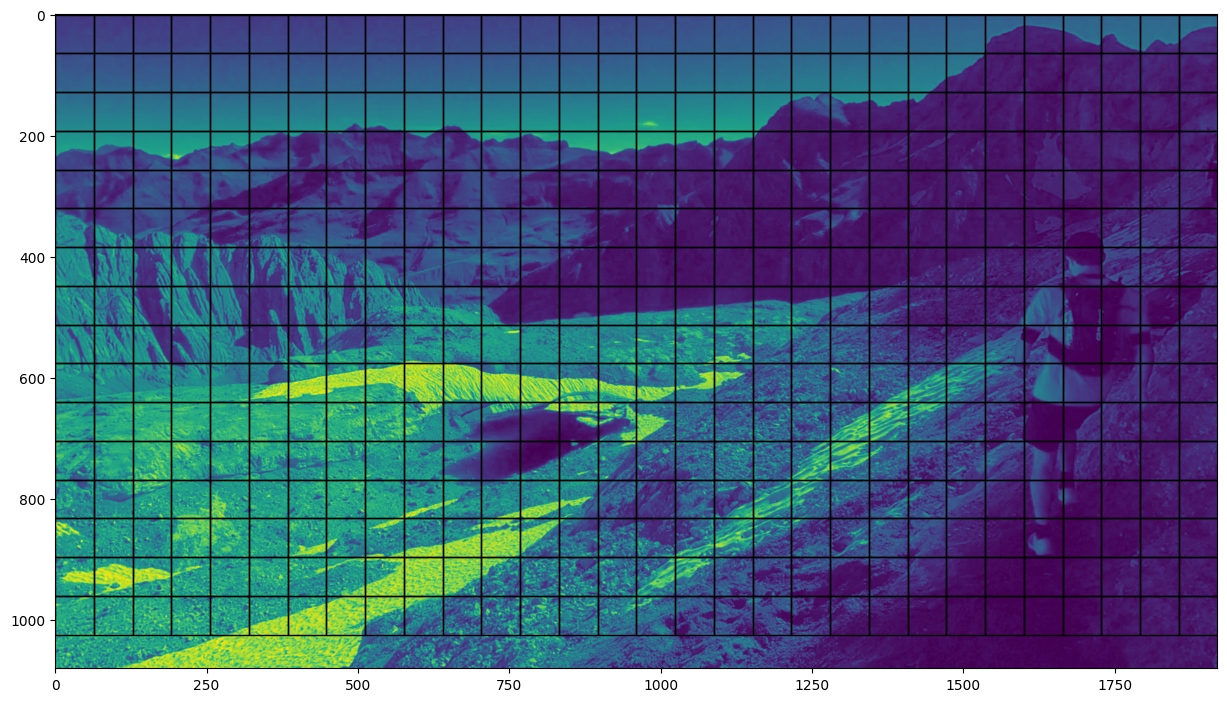

In [82]:
visualize_block(ipred, 64)